# Tomato Disease Classification Project

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

### Data Collection and Preprocessing

In [37]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 80 
"""
Version 1 = 20 epochs, Version 2 = 30 epochs, Version 3 = 50 epochs, Version 4 = 60 epochs
Version 5 includes one randomcontrast layer in data augmentation with 60 epochs.
Version 6 includes one  randomcontrast and one randomzoom layer.
Version 7 includes 80 epochs
"""

'\nVersion 1 = 20 epochs, Version 2 = 30 epochs, Version 3 = 50 epochs, Version 4 = 60 epochs\nVersion 5 includes one randomcontrast layer in data augmentation with 60 epochs.\nVersion 6 includes one  randomcontrast and one randomzoom layer.\nVersion 7 includes 80 epochs\n'

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2999 files belonging to 10 classes.


In [39]:
class_names = dataset.class_names

In [40]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__YellowLeaf__Curl_Virus',
 'Tomato__mosaic_virus',
 'Tomato_healthy']

In [41]:
len(dataset)

94

In [42]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 7 7 7 3 5 7 6 6 9 5 3 3 4 2 6 8 4 1 8 9 1 8 0 9 1 9 3 6 4 8 5]


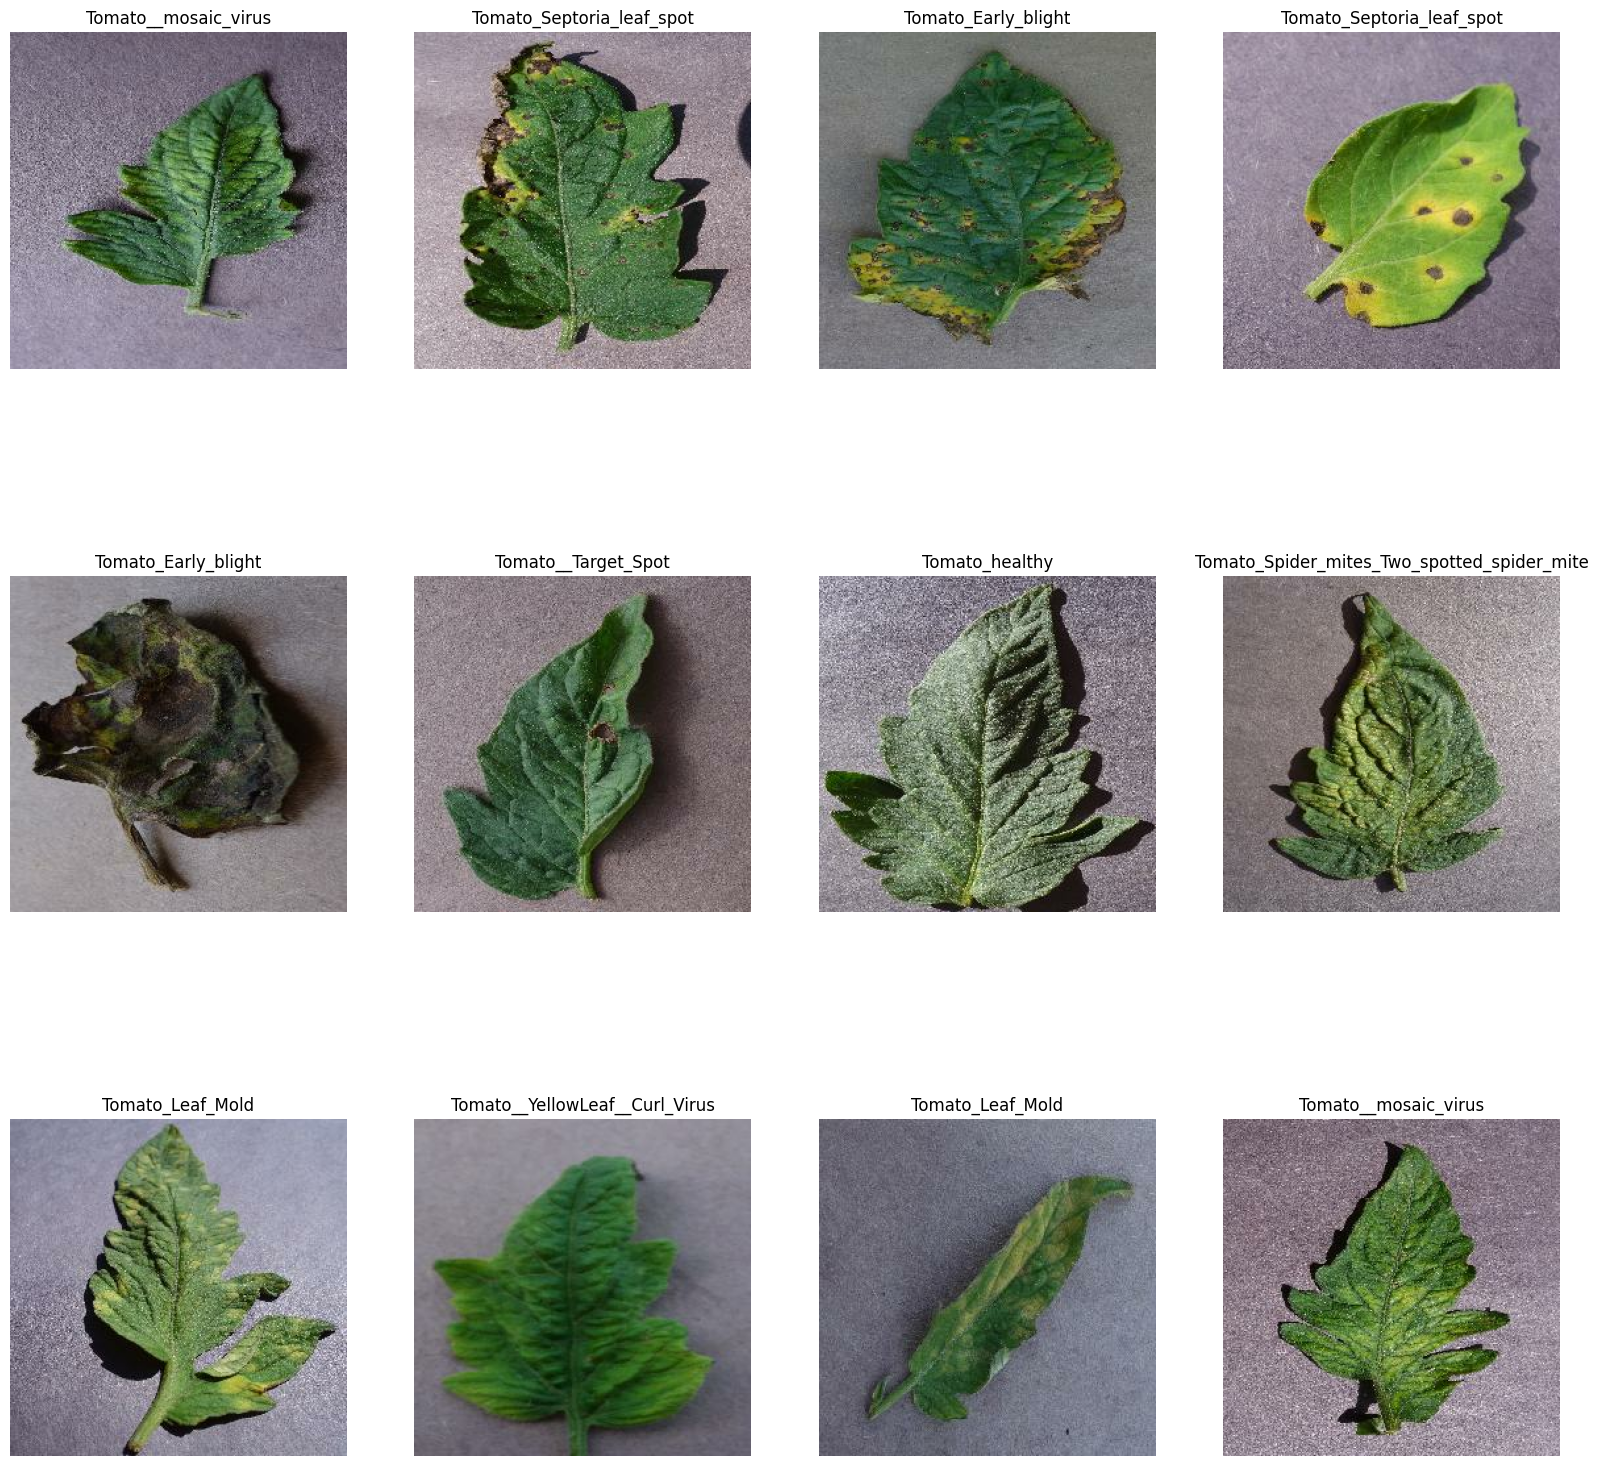

In [43]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [44]:
train_size = 0.8
len(dataset)*train_size

75.2

In [45]:
train_ds = dataset.take(75)
len(train_ds)

75

In [46]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [47]:
val_size = 0.1
len(dataset)*val_size

9.4

In [48]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [49]:
test_ds = test_ds.skip(9)
len(test_ds)

10

## Splitting the Data

In [50]:
def train_test_split(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [51]:
train_ds, val_ds, test_ds = train_test_split(dataset)

In [52]:
print(f"Length of train dataset: {len(train_ds)}\n Length of test dataset: {len(test_ds)}\n Length of val dataset: {len(val_ds)}")

Length of train dataset: 75
 Length of test dataset: 10
 Length of val dataset: 9


In [53]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [55]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Training the Model

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [58]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [59]:
history = model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/80


c:\users\a k com\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 132s 2s/step - loss: 2.2013 - accuracy: 0.1510 - val_loss: 2.0024 - val_accuracy: 0.2222
Epoch 2/80
75/75 [==============================] - 119s 2s/step - loss: 1.9175 - accuracy: 0.2714 - val_loss: 1.9785 - val_accuracy: 0.2222
Epoch 3/80
75/75 [==============================] - 119s 2s/step - loss: 1.7832 - accuracy: 0.3329 - val_loss: 2.0161 - val_accuracy: 0.2812
Epoch 4/80
75/75 [==============================] - 119s 2s/step - loss: 1.4974 - accuracy: 0.4555 - val_loss: 1.7660 - val_accuracy: 0.3819
Epoch 5/80
75/75 [==============================] - 119s 2s/step - loss: 1.3783 - accuracy: 0.4981 - val_loss: 2.6074 - val_accuracy: 0.3021
Epoch 6/80
75/75 [==============================] - 119s 2s/step - loss: 1.1963 - accuracy: 0.5638 - val_loss: 1.4215 - val_accuracy: 0.5243
Epoch 7/80
75/75 [==============================] - 119s 2s/step - loss: 1.1145 - accuracy: 0.5960 - val_loss: 1.7093 - val_accuracy: 0.4792
Epoch 8/80
75/75 [======

Epoch 59/80
75/75 [==============================] - 126s 2s/step - loss: 0.1242 - accuracy: 0.9582 - val_loss: 0.7741 - val_accuracy: 0.7812
Epoch 60/80
75/75 [==============================] - 120s 2s/step - loss: 0.1509 - accuracy: 0.9448 - val_loss: 0.7115 - val_accuracy: 0.8125
Epoch 61/80
75/75 [==============================] - 129s 2s/step - loss: 0.1306 - accuracy: 0.9552 - val_loss: 0.4677 - val_accuracy: 0.8750
Epoch 62/80
75/75 [==============================] - 125s 2s/step - loss: 0.1675 - accuracy: 0.9427 - val_loss: 0.7121 - val_accuracy: 0.8056
Epoch 63/80
75/75 [==============================] - 124s 2s/step - loss: 0.1435 - accuracy: 0.9494 - val_loss: 0.4614 - val_accuracy: 0.8785
Epoch 64/80
75/75 [==============================] - 125s 2s/step - loss: 0.0769 - accuracy: 0.9737 - val_loss: 0.5939 - val_accuracy: 0.8542
Epoch 65/80
75/75 [==============================] - 140s 2s/step - loss: 0.0921 - accuracy: 0.9670 - val_loss: 0.6265 - val_accuracy: 0.8368
Epoch 

In [60]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 28s 407ms/step - loss: 1.0198 - accuracy: 0.7812


In [61]:
scores

[1.0197713375091553, 0.78125]

In [62]:
history

In [63]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 75}

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

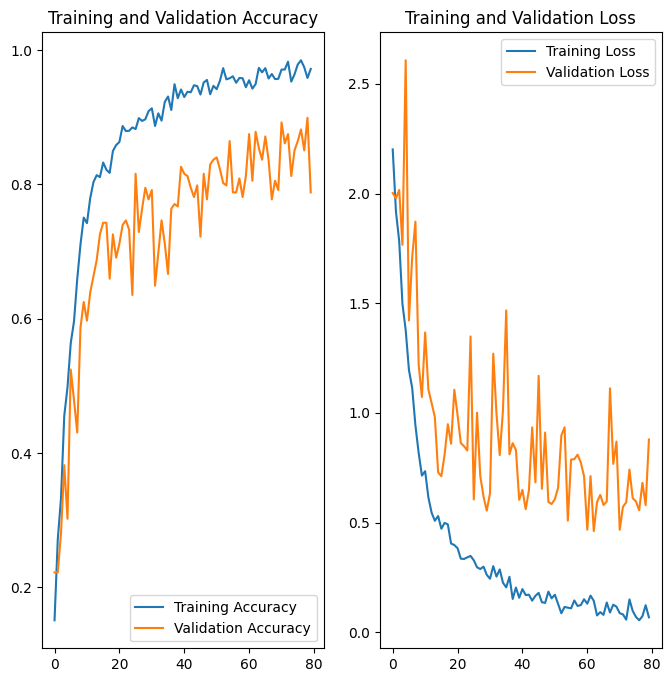

In [66]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

First Image to Predict:
Actual Label: Tomato__Target_Spot
1/1 [==============================] - 1s 722ms/step
Predicted Label: Tomato__Target_Spot


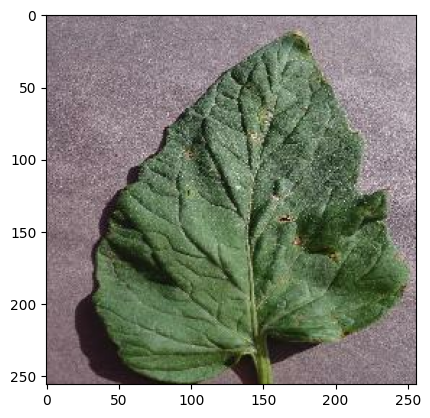

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First Image to Predict:")
    plt.imshow(first_image)
    print(f"Actual Label: {class_names[labels_batch[0]]}")
    
    batch_prediction = model.predict(images_batch)
    print(f"Predicted Label: {class_names[np.argmax(batch_prediction[0])]}")

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


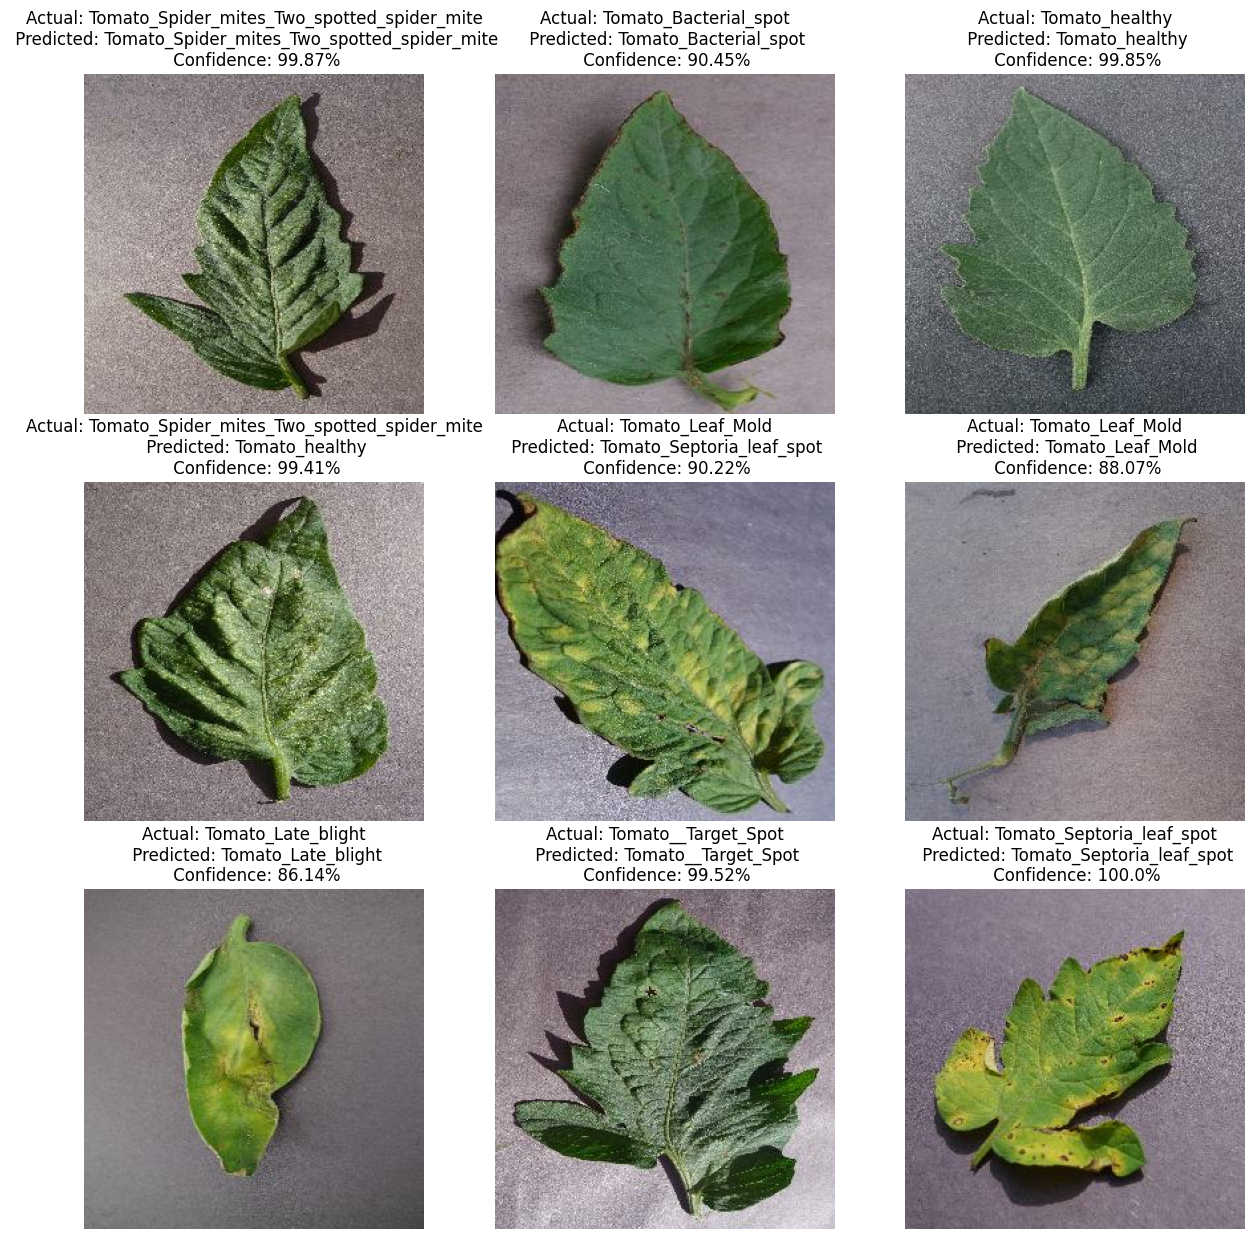

In [69]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis("off")

In [70]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/6\assets


INFO:tensorflow:Assets written to: ../saved_models/6\assets
